In [1]:
#inspired by: https://epjdatascience.springeropen.com/articles/10.1140/epjds/s13688-021-00265-y
#road characteristics: https://ddotwiki.atlassian.net/wiki/spaces/GIS0225/pages/2053603521/Roadway+Characteristics

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import geopandas as gpd
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb

In [3]:
bc_seg_sb = gpd.read_file(r'../DC_data/bc_seg_sb.geojson')

## get some stats/do some clean up

In [4]:
for c in bc_seg_sb.columns:
    print(c)

crashID
REPORTDATE
LATITUDE
LONGITUDE
MAJORINJURIES_BICYCLIST
MINORINJURIES_BICYCLIST
UNKNOWNINJURIES_BICYCLIST
FATAL_BICYCLIST
BICYCLISTSIMPAIRED
sev
index_right_bc_seg
SegID
startPoints
endPoints
PointID_start
geometry_start
PointID_end
geometry_end
straight_len
len
curve
betweenness
seg_geom
dist_to_road
dist_end1
dist_end2
intersection_dist
index_right
ROUTEID
FROMMEASURE
TOMEASURE
ROUTENAME
ROADTYPE
SUBBLOCKKEY
TOTALTRAVELLANES
TOTALPARKINGLANES
TOTALRAISEDBUFFERS
TOTALTRAVELLANEWIDTH
TOTALCROSSSECTIONWIDTH
TOTALPARKINGLANEWIDTH
TOTALTRAVELLANESINBOUND
TOTALTRAVELLANESOUTBOUND
TOTALTRAVELLANESBIDIRECTIONAL
TOTALTRAVELLANESREVERSIBLE
SUMMARYDIRECTION
BIKELANE_PARKINGLANE_ADJACENT
BIKELANE_THROUGHLANE_ADJACENT
BIKELANE_POCKETLANE_ADJACENT
BIKELANE_CONTRAFLOW
BIKELANE_CONVENTIONAL
BIKELANE_DUAL_PROTECTED
BIKELANE_DUAL_BUFFERED
BIKELANE_PROTECTED
BIKELANE_BUFFERED
DOUBLEYELLOW_LINE
SECTIONFLAGS
LOC_ERROR
MIDMEASURE
AADT
FHWAFUNCTIONALCLASS
HPMSID
HPMSSECTIONTYPE
ID
IRI
IRI_DATE
NHSCOD

In [5]:
bc_seg_sb['BIKELANE_DUAL_PROTECTED'].isnull().sum()

np.int64(5072)

In [6]:
#bikelane info: 0 means no bike lane indication, 1 means bikelane but nto protected/buffered, 2 is protected or buffered
#directionality still an issue
bc_seg_sb['bike_summary'] = 0
good = (bc_seg_sb['BIKELANE_DUAL_PROTECTED'].isin(['IB', 'OB', 'BD'])) | (bc_seg_sb['BIKELANE_DUAL_BUFFERED'].isin(['IB', 'OB', 'BD'])) | (bc_seg_sb['BIKELANE_PROTECTED'].isin(['IB', 'OB', 'BD'])) | (bc_seg_sb['BIKELANE_BUFFERED'].isin(['IB', 'OB', 'BD']) )
bc_seg_sb.loc[good, 'bike_summary'] = 2
ok = (bc_seg_sb['bike_summary'] == 0) &((bc_seg_sb['BIKELANE_PARKINGLANE_ADJACENT'].isin(['IB', 'OB', 'BD'])) | (bc_seg_sb['BIKELANE_THROUGHLANE_ADJACENT'].isin(['IB', 'OB', 'BD'])) | (bc_seg_sb['BIKELANE_POCKETLANE_ADJACENT'].isin(['IB', 'OB', 'BD'])) | (bc_seg_sb['BIKELANE_CONTRAFLOW'].isin(['IB', 'OB', 'BD'])) | (bc_seg_sb['BIKELANE_CONVENTIONAL'].isin(['IB', 'OB', 'BD'])))
bc_seg_sb.loc[ok, 'bike_summary'] = 1
bc_seg_sb

,crashID,REPORTDATE,LATITUDE,LONGITUDE,MAJORINJURIES_BICYCLIST,MINORINJURIES_BICYCLIST,UNKNOWNINJURIES_BICYCLIST,FATAL_BICYCLIST,BICYCLISTSIMPAIRED,sev,...,NETWORK_LOGICAL_END,AADT_COMBINATION,AADT_COMBINATION_YEAR,AADT_SINGLE_UNIT,AADT_SINGLE_UNIT_YEAR,OBJECTID,SHAPELEN,dist_to_sb,geometry,bike_summary
0,797,2012-05-04 10:28:00+00:00,38.905659,-77.029621,1,0,0,0,0,1,...,None,200.0,2020.0,1231.0,2020.0,9351230,0,0.154373,POINT (324010.556 4308265.657),1
1,826,2011-11-09 05:00:00+00:00,38.901336,-77.034593,1,0,0,0,0,1,...,None,NaN,NaN,NaN,NaN,9360131,0,0.226896,POINT (323568.689 4307795.481),2
2,863,2012-04-06 12:59:00+00:00,38.936279,-77.029725,1,0,0,0,0,1,...,None,107.0,2020.0,333.0,2020.0,9351299,0,0.228452,POINT (324077.203 4311664.2),0
3,1023,2012-01-30 00:00:00+00:00,38.907244,-77.023979,0,1,0,0,0,0,...,None,NaN,NaN,NaN,NaN,9357386,0,0.807391,POINT (324503.725 4308430.693),0
4,1043,2012-06-27 04:00:00+00:00,38.924752,-77.067880,1,0,0,0,0,1,...,None,NaN,NaN,NaN,NaN,9356935,0,0.472877,POINT (320740.858 4310459.23),0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5254,338157,2025-10-18 05:58:00+00:00,38.911788,-77.048433,0,1,0,0,0,0,...,None,15.0,2020.0,330.0,2020.0,9354858,0,0.740630,POINT (322394.492 4308982.358),0
5255,338168,2025-10-18 18:59:00+00:00,38.917186,-77.026291,0,1,0,0,0,0,...,None,NaN,NaN,NaN,NaN,9380724,0,14.745795,POINT (324327.758 4309538.55),0
5256,338207,2025-10-16 20:10:00+00:00,38.903581,-76.994556,0,1,0,0,0,0,...,None,NaN,NaN,NaN,NaN,9374712,0,0.219052,POINT (327046.28 4307967.941),0
5257,338223,2025-10-16 20:40:00+00:00,38.863587,-76.991143,0,1,0,0,0,0,...,None,NaN,NaN,NaN,NaN,9368641,0,0.279586,POINT (327245.387 4303522.811),0


In [7]:
bc_seg_sb['speed_summary'] = bc_seg_sb[['SPEEDLIMITS_IB','SPEEDLIMITS_OB']].mean(axis = 1)

In [80]:
keep = [ 'ROADTYPE','TOTALTRAVELLANES', 'TOTALPARKINGLANES', 'TOTALCROSSSECTIONWIDTH','bike_summary']
# 'betweenness', 'intersection_dist', 'curve' <- can't use if only then applying to dc data

In [9]:
#ROADTYPE and bike_summary are categorical
#speed_summary- too many NaN's?
for c in ['sev', 'ROADTYPE','TOTALTRAVELLANES', 'TOTALPARKINGLANES', 'bike_summary', 'speed_summary']:
    print('-----------'+c+'-------------')
    print(bc_seg_sb[c].value_counts(dropna = False))
    print(sum(bc_seg_sb[c].value_counts(dropna = False)))

-----------sev-------------
sev
0    4701
1     558
Name: count, dtype: int64
5259
-----------ROADTYPE-------------
ROADTYPE
1    4201
4     776
5     194
2      45
3      29
6      14
Name: count, dtype: int64
5259
-----------TOTALTRAVELLANES-------------
TOTALTRAVELLANES
2    1836
1     824
0     804
4     738
3     564
5     266
6     173
7      31
8      22
9       1
Name: count, dtype: int64
5259
-----------TOTALPARKINGLANES-------------
TOTALPARKINGLANES
2    2502
0    1890
1     749
3     112
4       6
Name: count, dtype: int64
5259
-----------bike_summary-------------
bike_summary
0    4077
1     692
2     490
Name: count, dtype: int64
5259
-----------speed_summary-------------
speed_summary
20.0    2268
NaN     1577
25.0    1046
30.0     294
35.0      39
15.0      30
0.0        5
Name: count, dtype: int64
5259


--------betweenness---------
0


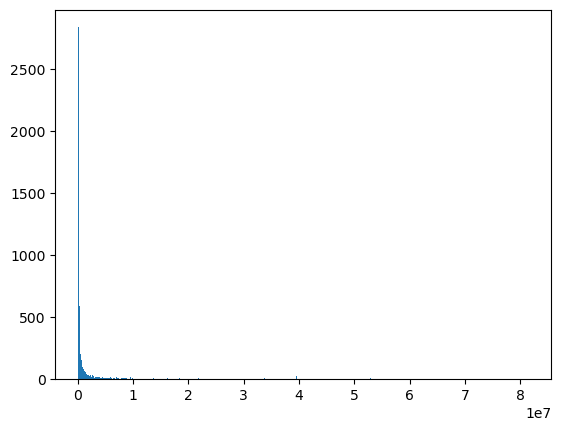

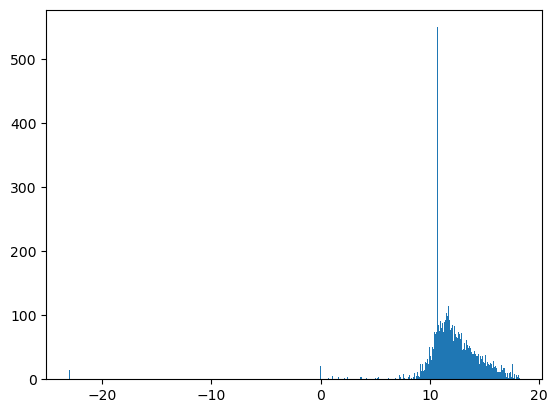

--------intersection_dist---------
0


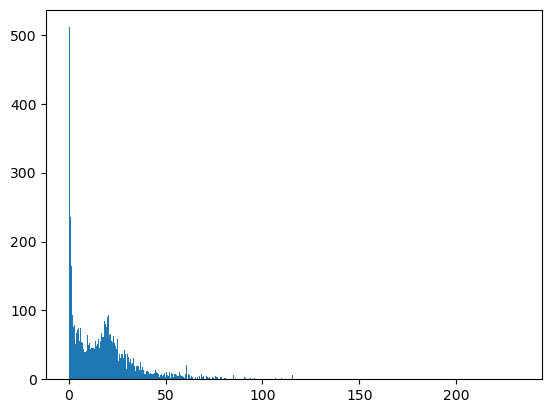

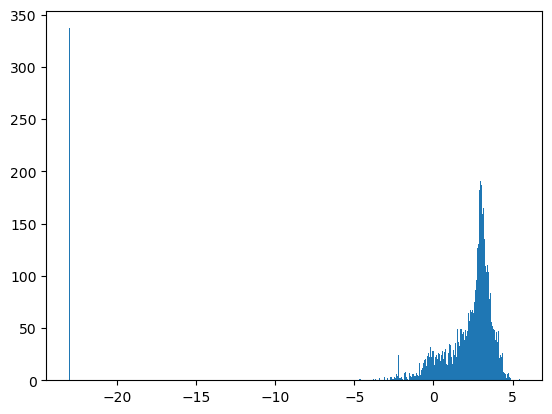

--------curve---------
0


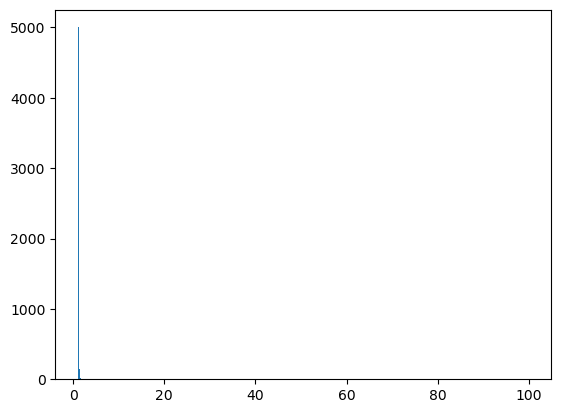

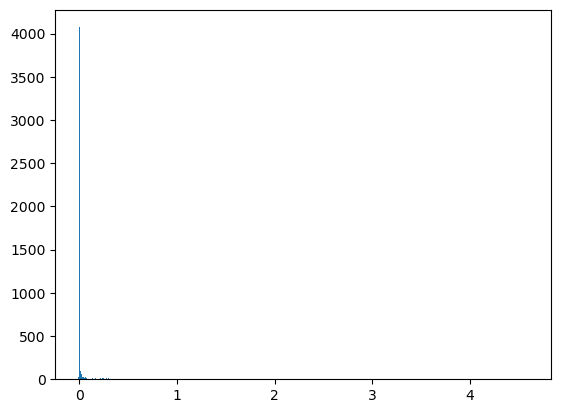

--------AADT---------
2368


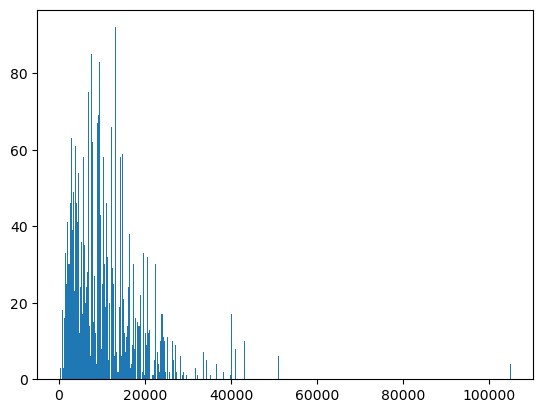

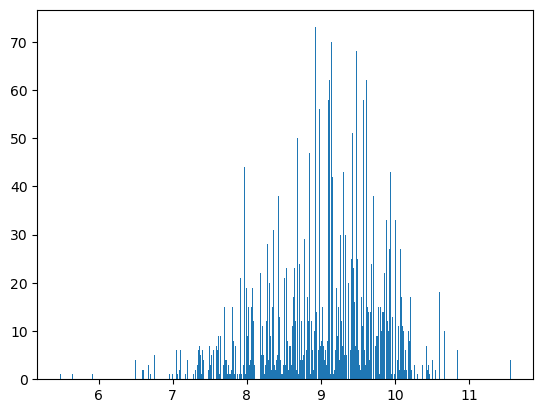

In [10]:
#don't use AADT cause only available for like half roads
for c in ['betweenness', 'intersection_dist', 'curve', 'AADT']:
    print('--------'+c+'---------')
    print(bc_seg_sb[c].isnull().sum())
    plt.hist(bc_seg_sb[c], bins = 500)
    plt.show()
    plt.hist(np.log(bc_seg_sb[c]+10**-10), bins = 500)
    plt.show()

In [71]:
y = bc_seg_sb['sev']
x = bc_seg_sb[keep]
x = pd.merge(x, pd.get_dummies(x['ROADTYPE'], prefix = 'ROADTYPE_', drop_first = True), left_index=True, right_index=True)
x = pd.merge(x, pd.get_dummies(x['bike_summary'], prefix = 'bike_summary', drop_first = True), left_index=True, right_index=True)
x = x.drop(columns = ['ROADTYPE', 'bike_summary'])
x

,TOTALTRAVELLANES,TOTALPARKINGLANES,TOTALCROSSSECTIONWIDTH,ROADTYPE__2,ROADTYPE__3,ROADTYPE__4,ROADTYPE__5,ROADTYPE__6,bike_summary_1,bike_summary_2
0,4,2,64,False,False,False,False,False,True,False
1,3,2,74,False,False,False,False,False,False,True
2,2,2,39,False,False,False,False,False,False,False
3,2,2,32,False,False,False,False,False,False,False
4,4,0,41,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
5254,2,2,45,False,False,False,False,False,False,False
5255,1,0,8,False,False,True,False,False,False,False
5256,1,0,11,False,False,True,False,False,False,False
5257,2,2,32,False,False,False,False,False,False,False


In [12]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [13]:
model = LogisticRegression(solver='liblinear', class_weight = 'balanced', random_state=42) # Choose a solver, e.g., 'liblinear', 'lbfgs'
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'liblinear'
,max_iter,100
,multi_class,'deprecated'


In [14]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test) # Get probabilities for each class

In [15]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.12547528517110265

Confusion Matrix:
 [[ 11 920]
 [  0 121]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.01      0.02       931
           1       0.12      1.00      0.21       121

    accuracy                           0.13      1052
   macro avg       0.56      0.51      0.12      1052
weighted avg       0.90      0.13      0.04      1052



In [72]:
y = bc_seg_sb['sev'].astype('category')
x = bc_seg_sb[keep]#+['speed_summary']]
x['bike_summary'] = x['bike_summary'].astype('category')
x['ROADTYPE'] = x['ROADTYPE'].astype('category')
#x['speed_summary'] = x['speed_summary'].astype(float)
x

C:\Users\cle9a\AppData\Local\Temp\ipykernel_33328\184202569.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['bike_summary'] = x['bike_summary'].astype('category')
C:\Users\cle9a\AppData\Local\Temp\ipykernel_33328\184202569.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['ROADTYPE'] = x['ROADTYPE'].astype('category')


,ROADTYPE,TOTALTRAVELLANES,TOTALPARKINGLANES,TOTALCROSSSECTIONWIDTH,bike_summary
0,1,4,2,64,1
1,1,3,2,74,2
2,1,2,2,39,0
3,1,2,2,32,0
4,1,4,0,41,0
...,...,...,...,...,...
5254,1,2,2,45,0
5255,4,1,0,8,0
5256,4,1,0,11,0
5257,1,2,2,32,0


In [29]:
x['speed_summary'].type()

AttributeError: 'Series' object has no attribute 'type'

In [73]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [74]:
from sklearn.utils.class_weight import compute_class_weight

# calculate class weights based on the training data
class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=y_train)
class_weights

scale_pos_weight = sum(y_train == 0)/sum(y_train == 1)
scale_pos_weight

8.62700228832952

In [75]:
model = xgb.XGBClassifier(objective='binary:logistic',
                          n_estimators=100,
                          learning_rate=0.1,
                          max_depth=3,
                          eval_metric='logloss',# Set a suitable evaluation metric
                         enable_categorical = True,
                         scale_pos_weight = scale_pos_weight) 

# Fit the model to the training data
model.fit(X_train, y_train, eval_set = [(X_test, y_test)], verbose = True)

[0]	validation_0-logloss:0.69244
[1]	validation_0-logloss:0.69181
[2]	validation_0-logloss:0.69095
[3]	validation_0-logloss:0.69029
[4]	validation_0-logloss:0.68973
[5]	validation_0-logloss:0.68934
[6]	validation_0-logloss:0.68895
[7]	validation_0-logloss:0.68842
[8]	validation_0-logloss:0.68808
[9]	validation_0-logloss:0.68776
[10]	validation_0-logloss:0.68745
[11]	validation_0-logloss:0.68703
[12]	validation_0-logloss:0.68694
[13]	validation_0-logloss:0.68660
[14]	validation_0-logloss:0.68641
[15]	validation_0-logloss:0.68601
[16]	validation_0-logloss:0.68589
[17]	validation_0-logloss:0.68557
[18]	validation_0-logloss:0.68544
[19]	validation_0-logloss:0.68524
[20]	validation_0-logloss:0.68496
[21]	validation_0-logloss:0.68473
[22]	validation_0-logloss:0.68473
[23]	validation_0-logloss:0.68446
[24]	validation_0-logloss:0.68437
[25]	validation_0-logloss:0.68465
[26]	validation_0-logloss:0.68449
[27]	validation_0-logloss:0.68441
[28]	validation_0-logloss:0.68438
[29]	validation_0-loglos

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,True
,eval_metric,'logloss'


In [76]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test) # Get probabilities for each class

In [77]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.5665399239543726

Confusion Matrix:
 [[544 387]
 [ 69  52]]

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.58      0.70       931
           1       0.12      0.43      0.19       121

    accuracy                           0.57      1052
   macro avg       0.50      0.51      0.45      1052
weighted avg       0.80      0.57      0.64      1052



In [78]:
y_pred_proba

array([[0.60968506, 0.39031497],
       [0.7327104 , 0.26728958],
       [0.502454  , 0.49754602],
       ...,
       [0.5207803 , 0.47921968],
       [0.5207803 , 0.47921968],
       [0.44227546, 0.55772454]], shape=(1052, 2), dtype=float32)

In [79]:
y_pred

array([0, 0, 0, ..., 0, 0, 1], shape=(1052,))

## Apply model to all road segments

In [81]:
sb = gpd.read_file(r'../DC_data/Roadway_SubBlock.geojson')
sb = sb.to_crs(sb.estimate_utm_crs())
sb

,ROUTEID,FROMMEASURE,TOMEASURE,ROUTENAME,ROADTYPE,SUBBLOCKKEY,TOTALTRAVELLANES,TOTALPARKINGLANES,TOTALRAISEDBUFFERS,TOTALTRAVELLANEWIDTH,...,SMD_ID,ANC_ID,NETWORK_LOGICAL_END,AADT_COMBINATION,AADT_COMBINATION_YEAR,AADT_SINGLE_UNIT,AADT_SINGLE_UNIT_YEAR,OBJECTID,SHAPELEN,geometry
0,11000302,893.711670,944.862671,3RD ST NW,1,85c142bcb3d0019d55dd06f435923386,3,3,0,39,...,6E08,6E,None,NaN,NaN,NaN,NaN,9348470,0,"LINESTRING Z (325243.866 4307371.344 0, 325244..."
1,11000302,2494.385742,2531.276611,3RD ST NW,1,1fc875db24cc6dc749a21b6b2c91a7b4,2,3,0,16,...,4C07,4C,None,NaN,NaN,NaN,NaN,9348471,0,"LINESTRING Z (325336.378 4312052.727 0, 325336..."
2,11000302,2167.569580,2216.123535,3RD ST NW,1,a829b3d03a550301b9091050da7e31db,2,2,0,24,...,1B01,1B,None,NaN,NaN,NaN,NaN,9348472,0,"LINESTRING Z (325235.645 4309218.55 0, 325236...."
3,11000302,2079.489990,2111.326904,3RD ST NW,1,024154cc3185f8763181362cb4bc642f,3,1,0,44,...,5E03,5E,None,NaN,NaN,NaN,NaN,9348473,0,"LINESTRING Z (325223.682 4309131.711 0, 325227..."
4,11000302,4592.641602,4746.591797,3RD ST NW,1,0d6f557dac0ced632844676fe8f11922,2,2,0,24,...,4B06,4B,None,22.0,2020.0,63.0,2020.0,9348474,0,"LINESTRING Z (325313.876 4314417.66 0, 325314...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34918,64010532,881.278992,938.133972,ANACOSTIA RIVER TRAIL SW,6,f0171b9d7102bcfc8dcd4f6c63cbc1ff,0,0,0,0,...,8C01,8C,None,NaN,NaN,NaN,NaN,9385004,0,"LINESTRING Z (326239.903 4303935.843 0, 326240..."
34919,64010532,4858.782227,5297.869141,ANACOSTIA RIVER TRAIL SW,6,8f77b7912a871e36cd1bfd4f761310b7,0,0,0,0,...,8D07,8D,None,NaN,NaN,NaN,NaN,9385005,0,"LINESTRING Z (324860.699 4299650.293 0, 324871..."
34920,64010532,5297.869141,5516.471680,ANACOSTIA RIVER TRAIL SW,6,b3f8f13b4c8c9a5114e3887ca0240a7d,0,0,0,0,...,8D04,8D,None,NaN,NaN,NaN,NaN,9385006,0,"LINESTRING Z (324873.581 4299224.71 0, 324880...."
34921,64010532,233.360001,881.278992,ANACOSTIA RIVER TRAIL SW,6,60c5c3672b3865524252af7b2d885906,0,0,0,0,...,6D08,6D,None,NaN,NaN,NaN,NaN,9385007,0,"LINESTRING Z (325670.523 4304211.453 0, 325677..."


In [82]:
sb['bike_summary'] = 0
good = (sb['BIKELANE_DUAL_PROTECTED'].isin(['IB', 'OB', 'BD'])) | (sb['BIKELANE_DUAL_BUFFERED'].isin(['IB', 'OB', 'BD'])) | (sb['BIKELANE_PROTECTED'].isin(['IB', 'OB', 'BD'])) | (sb['BIKELANE_BUFFERED'].isin(['IB', 'OB', 'BD']) )
sb.loc[good, 'bike_summary'] = 2
ok = (sb['bike_summary'] == 0) &((sb['BIKELANE_PARKINGLANE_ADJACENT'].isin(['IB', 'OB', 'BD'])) | (sb['BIKELANE_THROUGHLANE_ADJACENT'].isin(['IB', 'OB', 'BD'])) | (sb['BIKELANE_POCKETLANE_ADJACENT'].isin(['IB', 'OB', 'BD'])) | (sb['BIKELANE_CONTRAFLOW'].isin(['IB', 'OB', 'BD'])) | (sb['BIKELANE_CONVENTIONAL'].isin(['IB', 'OB', 'BD'])))
sb.loc[ok, 'bike_summary'] = 1
sb

,ROUTEID,FROMMEASURE,TOMEASURE,ROUTENAME,ROADTYPE,SUBBLOCKKEY,TOTALTRAVELLANES,TOTALPARKINGLANES,TOTALRAISEDBUFFERS,TOTALTRAVELLANEWIDTH,...,ANC_ID,NETWORK_LOGICAL_END,AADT_COMBINATION,AADT_COMBINATION_YEAR,AADT_SINGLE_UNIT,AADT_SINGLE_UNIT_YEAR,OBJECTID,SHAPELEN,geometry,bike_summary
0,11000302,893.711670,944.862671,3RD ST NW,1,85c142bcb3d0019d55dd06f435923386,3,3,0,39,...,6E,None,NaN,NaN,NaN,NaN,9348470,0,"LINESTRING Z (325243.866 4307371.344 0, 325244...",0
1,11000302,2494.385742,2531.276611,3RD ST NW,1,1fc875db24cc6dc749a21b6b2c91a7b4,2,3,0,16,...,4C,None,NaN,NaN,NaN,NaN,9348471,0,"LINESTRING Z (325336.378 4312052.727 0, 325336...",0
2,11000302,2167.569580,2216.123535,3RD ST NW,1,a829b3d03a550301b9091050da7e31db,2,2,0,24,...,1B,None,NaN,NaN,NaN,NaN,9348472,0,"LINESTRING Z (325235.645 4309218.55 0, 325236....",0
3,11000302,2079.489990,2111.326904,3RD ST NW,1,024154cc3185f8763181362cb4bc642f,3,1,0,44,...,5E,None,NaN,NaN,NaN,NaN,9348473,0,"LINESTRING Z (325223.682 4309131.711 0, 325227...",0
4,11000302,4592.641602,4746.591797,3RD ST NW,1,0d6f557dac0ced632844676fe8f11922,2,2,0,24,...,4B,None,22.0,2020.0,63.0,2020.0,9348474,0,"LINESTRING Z (325313.876 4314417.66 0, 325314....",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34918,64010532,881.278992,938.133972,ANACOSTIA RIVER TRAIL SW,6,f0171b9d7102bcfc8dcd4f6c63cbc1ff,0,0,0,0,...,8C,None,NaN,NaN,NaN,NaN,9385004,0,"LINESTRING Z (326239.903 4303935.843 0, 326240...",0
34919,64010532,4858.782227,5297.869141,ANACOSTIA RIVER TRAIL SW,6,8f77b7912a871e36cd1bfd4f761310b7,0,0,0,0,...,8D,None,NaN,NaN,NaN,NaN,9385005,0,"LINESTRING Z (324860.699 4299650.293 0, 324871...",0
34920,64010532,5297.869141,5516.471680,ANACOSTIA RIVER TRAIL SW,6,b3f8f13b4c8c9a5114e3887ca0240a7d,0,0,0,0,...,8D,None,NaN,NaN,NaN,NaN,9385006,0,"LINESTRING Z (324873.581 4299224.71 0, 324880....",0
34921,64010532,233.360001,881.278992,ANACOSTIA RIVER TRAIL SW,6,60c5c3672b3865524252af7b2d885906,0,0,0,0,...,6D,None,NaN,NaN,NaN,NaN,9385007,0,"LINESTRING Z (325670.523 4304211.453 0, 325677...",0


In [92]:
sb['speed_summary'] = sb[['SPEEDLIMITS_IB','SPEEDLIMITS_OB']].mean(axis = 1)
sb = sb[sb['ROADTYPE'] != '7'] #not in training set
sb

,ROUTEID,FROMMEASURE,TOMEASURE,ROUTENAME,ROADTYPE,SUBBLOCKKEY,TOTALTRAVELLANES,TOTALPARKINGLANES,TOTALRAISEDBUFFERS,TOTALTRAVELLANEWIDTH,...,NETWORK_LOGICAL_END,AADT_COMBINATION,AADT_COMBINATION_YEAR,AADT_SINGLE_UNIT,AADT_SINGLE_UNIT_YEAR,OBJECTID,SHAPELEN,geometry,bike_summary,speed_summary
0,11000302,893.711670,944.862671,3RD ST NW,1,85c142bcb3d0019d55dd06f435923386,3,3,0,39,...,None,NaN,NaN,NaN,NaN,9348470,0,"LINESTRING Z (325243.866 4307371.344 0, 325244...",0,20.0
1,11000302,2494.385742,2531.276611,3RD ST NW,1,1fc875db24cc6dc749a21b6b2c91a7b4,2,3,0,16,...,None,NaN,NaN,NaN,NaN,9348471,0,"LINESTRING Z (325336.378 4312052.727 0, 325336...",0,20.0
2,11000302,2167.569580,2216.123535,3RD ST NW,1,a829b3d03a550301b9091050da7e31db,2,2,0,24,...,None,NaN,NaN,NaN,NaN,9348472,0,"LINESTRING Z (325235.645 4309218.55 0, 325236....",0,20.0
3,11000302,2079.489990,2111.326904,3RD ST NW,1,024154cc3185f8763181362cb4bc642f,3,1,0,44,...,None,NaN,NaN,NaN,NaN,9348473,0,"LINESTRING Z (325223.682 4309131.711 0, 325227...",0,20.0
4,11000302,4592.641602,4746.591797,3RD ST NW,1,0d6f557dac0ced632844676fe8f11922,2,2,0,24,...,None,22.0,2020.0,63.0,2020.0,9348474,0,"LINESTRING Z (325313.876 4314417.66 0, 325314....",0,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34918,64010532,881.278992,938.133972,ANACOSTIA RIVER TRAIL SW,6,f0171b9d7102bcfc8dcd4f6c63cbc1ff,0,0,0,0,...,None,NaN,NaN,NaN,NaN,9385004,0,"LINESTRING Z (326239.903 4303935.843 0, 326240...",0,NaN
34919,64010532,4858.782227,5297.869141,ANACOSTIA RIVER TRAIL SW,6,8f77b7912a871e36cd1bfd4f761310b7,0,0,0,0,...,None,NaN,NaN,NaN,NaN,9385005,0,"LINESTRING Z (324860.699 4299650.293 0, 324871...",0,NaN
34920,64010532,5297.869141,5516.471680,ANACOSTIA RIVER TRAIL SW,6,b3f8f13b4c8c9a5114e3887ca0240a7d,0,0,0,0,...,None,NaN,NaN,NaN,NaN,9385006,0,"LINESTRING Z (324873.581 4299224.71 0, 324880....",0,NaN
34921,64010532,233.360001,881.278992,ANACOSTIA RIVER TRAIL SW,6,60c5c3672b3865524252af7b2d885906,0,0,0,0,...,None,NaN,NaN,NaN,NaN,9385007,0,"LINESTRING Z (325670.523 4304211.453 0, 325677...",0,NaN


In [93]:
keep = [ 'ROADTYPE','TOTALTRAVELLANES', 'TOTALPARKINGLANES', 'TOTALCROSSSECTIONWIDTH','bike_summary']
x_roads = sb[keep]#+['speed_summary']]
x_roads['bike_summary'] = x_roads['bike_summary'].astype('category')
x_roads['ROADTYPE'] = x_roads['ROADTYPE'].astype('category')
#x['speed_summary'] = x['speed_summary'].astype(float)
x_roads

C:\Users\cle9a\AppData\Local\Temp\ipykernel_33328\3960194458.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_roads['bike_summary'] = x_roads['bike_summary'].astype('category')
C:\Users\cle9a\AppData\Local\Temp\ipykernel_33328\3960194458.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_roads['ROADTYPE'] = x_roads['ROADTYPE'].astype('category')


,ROADTYPE,TOTALTRAVELLANES,TOTALPARKINGLANES,TOTALCROSSSECTIONWIDTH,bike_summary
0,1,3,3,57,0
1,1,2,3,40,0
2,1,2,2,41,0
3,1,3,1,53,0
4,1,2,2,41,0
...,...,...,...,...,...
34918,6,0,0,0,0
34919,6,0,0,0,0
34920,6,0,0,0,0
34921,6,0,0,0,0


In [96]:
y_pred_proba = model.predict_proba(x_roads)
sb['pred_proba'] = y_pred_proba[:,1]
sb

C:\Users\cle9a\anaconda3\envs\ridescore\Lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,ROUTEID,FROMMEASURE,TOMEASURE,ROUTENAME,ROADTYPE,SUBBLOCKKEY,TOTALTRAVELLANES,TOTALPARKINGLANES,TOTALRAISEDBUFFERS,TOTALTRAVELLANEWIDTH,...,AADT_COMBINATION,AADT_COMBINATION_YEAR,AADT_SINGLE_UNIT,AADT_SINGLE_UNIT_YEAR,OBJECTID,SHAPELEN,geometry,bike_summary,speed_summary,pred_proba
0,11000302,893.711670,944.862671,3RD ST NW,1,85c142bcb3d0019d55dd06f435923386,3,3,0,39,...,NaN,NaN,NaN,NaN,9348470,0,"LINESTRING Z (325243.866 4307371.344 0, 325244...",0,20.0,0.462338
1,11000302,2494.385742,2531.276611,3RD ST NW,1,1fc875db24cc6dc749a21b6b2c91a7b4,2,3,0,16,...,NaN,NaN,NaN,NaN,9348471,0,"LINESTRING Z (325336.378 4312052.727 0, 325336...",0,20.0,0.442963
2,11000302,2167.569580,2216.123535,3RD ST NW,1,a829b3d03a550301b9091050da7e31db,2,2,0,24,...,NaN,NaN,NaN,NaN,9348472,0,"LINESTRING Z (325235.645 4309218.55 0, 325236....",0,20.0,0.437731
3,11000302,2079.489990,2111.326904,3RD ST NW,1,024154cc3185f8763181362cb4bc642f,3,1,0,44,...,NaN,NaN,NaN,NaN,9348473,0,"LINESTRING Z (325223.682 4309131.711 0, 325227...",0,20.0,0.442033
4,11000302,4592.641602,4746.591797,3RD ST NW,1,0d6f557dac0ced632844676fe8f11922,2,2,0,24,...,22.0,2020.0,63.0,2020.0,9348474,0,"LINESTRING Z (325313.876 4314417.66 0, 325314....",0,25.0,0.437731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34918,64010532,881.278992,938.133972,ANACOSTIA RIVER TRAIL SW,6,f0171b9d7102bcfc8dcd4f6c63cbc1ff,0,0,0,0,...,NaN,NaN,NaN,NaN,9385004,0,"LINESTRING Z (326239.903 4303935.843 0, 326240...",0,NaN,0.121872
34919,64010532,4858.782227,5297.869141,ANACOSTIA RIVER TRAIL SW,6,8f77b7912a871e36cd1bfd4f761310b7,0,0,0,0,...,NaN,NaN,NaN,NaN,9385005,0,"LINESTRING Z (324860.699 4299650.293 0, 324871...",0,NaN,0.121872
34920,64010532,5297.869141,5516.471680,ANACOSTIA RIVER TRAIL SW,6,b3f8f13b4c8c9a5114e3887ca0240a7d,0,0,0,0,...,NaN,NaN,NaN,NaN,9385006,0,"LINESTRING Z (324873.581 4299224.71 0, 324880....",0,NaN,0.121872
34921,64010532,233.360001,881.278992,ANACOSTIA RIVER TRAIL SW,6,60c5c3672b3865524252af7b2d885906,0,0,0,0,...,NaN,NaN,NaN,NaN,9385007,0,"LINESTRING Z (325670.523 4304211.453 0, 325677...",0,NaN,0.121872


In [98]:
sb.to_file(r'../DC_data/Roadway_SubBlock_wPred.geojson')